Note:

(R) indicates an external resource(e.g. websites, articles). These are resources that assisted me in overcoming many pain-points while building this project, which usually are articles that provide an intuitive explaination for the functions used(e.g. the map function from pandas)

In [0]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.optimizers import *
from keras.metrics import *
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#Data

In [0]:
#mounting google drive -> Google Colab Only
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#dictionary to convert abbreviation of lesion types to full lesion type
type_dictionary = {
    'akiec' : 'Actinic Keratoses',
    'bcc' : 'Basal cell carcinoma',
    'bkl' : 'Benign keratosis',
    'df' : 'Dermatofibroma',
    'nv' : 'Melanocytic nevi',
    'mel' : 'Melanoma',
    'vasc' : 'Vascular skin lesions',
}

#root directory to HAM10000 dataset
root_dir = '/content/drive/My Drive/Datasets/HAM10000/'

In [0]:
#metadata dataframe
df = pd.read_csv('/content/drive/My Drive/Datasets/HAM10000/HAM10000_metadata.csv')

#make the column 'dx'(lesion type) the category datatype
df['dx']=df['dx'].astype('category')

#create a label column using the integer representation of the category / type of lesion
df['label']=df['dx'].cat.codes

#create a type column using 'dx'(abbreviation of lesion type) & map the values to full lesion type
df['type'] = df['dx'].map(type_dictionary)

df['path'] = root_dir + 'images/'+ df['image_id'].astype(str) + '.jpg'

#drop useless columns -> we are only predicting the type of lesion
df = df.drop(columns=['age', 'image_id', 'lesion_id', 'sex', 'dx_type', 'dx', 'localization'])

In [0]:
#creating image column
#(R) map function w lambdas: https://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.Series.map.html
df['image'] = df['path'].map(lambda x: np.array(Image.open(x).resize((100,75))))

In [0]:
df.to_pickle(root_dir+"/dataframe.pickle")

In [0]:
df = pd.read_pickle(root_dir+"/dataframe.pickle")

In [0]:
#Create training & testing tensors for features & labels
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size = 0.2)

#Create training & validation tensors
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.1)

#returns number of unique classes
num_classes = y_train.unique().size

#converting to np arrays
X_train = np.array(X_train.tolist())
X_validate = np.array(X_validate.tolist())
X_test = np.array(X_test.tolist())
# y_train = np.array(y_train)
# y_validate = np.array(y_validate)
# y_test = np.array(y_test)

# Normalisation
X_train = X_train/255
X_validate = X_validate/255
X_test = X_test/255

#Re-shaping data
X_train = X_train.reshape(X_train.shape[0], 75, 100, 3)
X_validate = X_validate.reshape(X_validate.shape[0], 75, 100, 3)
X_test = X_test.reshape(X_test.shape[0], 75, 100, 3)

#One-hot-encoding for labels
y_train = np_utils.to_categorical(y_train, num_classes)
y_validate = np_utils.to_categorical(y_validate, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# **Problem:** Data Imbalance


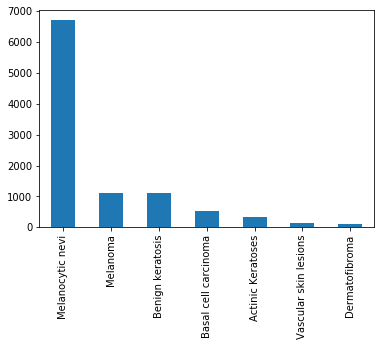

In [0]:
#df['type'].value_counts() returns the number of time each type of skin lesion appears in the dataset
#After plotting the data, it's clear there's a data imbalance
#(R) Learn more about plotting here: https://datatofish.com/plot-dataframe-pandas/ 
df['type'].value_counts().plot(kind='bar')

Because the data is unbalanced across all classes, the model will have a bias towards classes like "Melanocytic nevi".

(R) Here's an intuitive explaination for why data imbalance is bad: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

To balance the dataset, we will have to re-sample / essentially duplicate the less frequent samples, so that all classes have the same amount of samples. This method is called oversampling.

Or even better, we can use oversampling and Keras' ImageDataGenerator to augment images, this way you are introducing new data into the dataset instead just duplicating existing samples!

(R) Solution of oversampling + data augmentation was proposed here: https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9

In [0]:
#A custom class to generate images on-the-fly to balance a given dataset
#Code from: https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
#data augmentation + normalization
datagen = ImageDataGenerator()
balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

#Model

In [0]:
#(R) Model performance stats: https://github.com/jcjohnson/cnn-benchmarks
#^Chose ResNet because it performs the best according to the above benchmarks
resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(75, 100, 3))













94773248/94765736 [==============================] - 1s 0us/step


In [0]:
#setting the last layer of resnet to be a flatten layer
output = resnet_model.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = keras.Model(resnet_model.input, output=output)

#make layers untrainable
for layer in resnet_model.layers:
  layer.trainable=False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#creates model w 2 dense layers after resnet
#dropout is used to prevent overfitting
model = Sequential()
model.add(resnet_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
optimizer = keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

In [0]:
model.load_weights(root_dir+'weights')
model.fit_generator(balanced_gen, validation_data=(X_validate, y_validate), epochs=100, verbose=1)
model.save_weights(root_dir+'weights')

Epoch 1/100
225/225 [==============================] - 196s 873ms/step - loss: 0.2308 - acc: 0.9379 - val_loss: 1.4918 - val_acc: 0.6870
Epoch 2/100
225/225 [==============================] - 189s 841ms/step - loss: 0.2107 - acc: 0.9443 - val_loss: 1.1920 - val_acc: 0.6870
Epoch 3/100
225/225 [==============================] - 190s 842ms/step - loss: 0.1769 - acc: 0.9504 - val_loss: 1.6016 - val_acc: 0.6870
Epoch 4/100
225/225 [==============================] - 190s 843ms/step - loss: 0.1448 - acc: 0.9587 - val_loss: 1.1902 - val_acc: 0.6870
Epoch 5/100
225/225 [==============================] - 189s 841ms/step - loss: 0.1114 - acc: 0.9672 - val_loss: 1.2595 - val_acc: 0.6870
Epoch 6/100
225/225 [==============================] - 190s 843ms/step - loss: 0.1255 - acc: 0.9612 - val_loss: 2.2068 - val_acc: 0.6870
Epoch 7/100
225/225 [==============================] - 191s 849ms/step - loss: 0.1057 - acc: 0.9678 - val_loss: 1.6584 - val_acc: 0.6870
Epoch 8/100
225/225 [====================

In [0]:
model.evaluate(x=X_test, y=y_test)

2003/2003 [==============================] - 49s 25ms/step


[1.6618104976115082, 0.680978531963636]